# MOLE DETECTION  -- Mole Type --

#### Import Necessary Libraries

In [86]:
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight


import keras
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE



#### Constants

In [87]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'akiec',
    1: 'bcc',
    2: 'bkl',
    3: 'df',
    4: 'mel',
    5: 'nv',
    6: 'vasc'
}
labels = {
    0: 'Actinic keratoses (akiec)',
    1: 'Basal cell carcinoma (bcc)',
    2: 'Benign keratosis-like lesions (bkl)',
    3: 'Dermatofibroma (df)',
    4: 'Melanoma (mel)',
    5: 'Melanocytic nevi (nv)',
    6: 'Vascular lesions (vasc)',
}
int_label_mapping = dict((value, key) for key, value in label_mapping.items())

SIZE=32  # image size

#### Read the data

In [88]:

data = pd.read_csv('data/HAM10000_metadata.csv')

labele = LabelEncoder()
labele.fit(data['dx'])
data['label'] = labele.transform(data["dx"]) 

print(list(labele.classes_))



['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


### Class weights or resampling

In [72]:
#Class Weights
y=data['label']
class_weights = dict(zip(np.unique(y), class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y), 
                y=y))) 

class_weights


{0: 4.375273044997815,
 1: 2.78349082823791,
 2: 1.301832835044846,
 3: 12.440993788819876,
 4: 1.2854575792581184,
 5: 0.21338020666879728,
 6: 10.075452716297788}

In [90]:
ros = RandomOverSampler()


In [91]:
x=data
y=data['label']
data,y=ros.fit_resample(x, y)


In [93]:
data['label'].value_counts()

2    6705
5    6705
3    6705
4    6705
6    6705
1    6705
0    6705
Name: label, dtype: int64

In [73]:
#resampling
n_samples=500


from sklearn.utils import resample
print(data['label'].value_counts())

# Balancing the data
# tried balancing with class weights and imageprocessing best results came with resampling


df_0 = data[data['label'] == 0]
df_1 = data[data['label'] == 1]
df_2 = data[data['label'] == 2]
df_3 = data[data['label'] == 3]
df_4 = data[data['label'] == 4]
df_5 = data[data['label'] == 5]
df_6 = data[data['label'] == 6]


df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

#Combined back to a single dataframe
data_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

print(data_balanced['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64
0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


In [74]:
data=data_balanced

In [94]:
data['path'] = './data/HAM10000_images/' + data['image_id'] +".jpg"

In [95]:
data

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,./data/HAM10000_images/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,./data/HAM10000_images/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,./data/HAM10000_images/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,./data/HAM10000_images/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,./data/HAM10000_images/ISIC_0031633.jpg
...,...,...,...,...,...,...,...,...,...
46930,HAM_0000502,ISIC_0031093,vasc,consensus,70.0,male,back,6,./data/HAM10000_images/ISIC_0031093.jpg
46931,HAM_0005560,ISIC_0027269,vasc,consensus,60.0,female,trunk,6,./data/HAM10000_images/ISIC_0027269.jpg
46932,HAM_0006889,ISIC_0031270,vasc,histo,20.0,male,upper extremity,6,./data/HAM10000_images/ISIC_0031270.jpg
46933,HAM_0004257,ISIC_0025452,vasc,consensus,55.0,female,abdomen,6,./data/HAM10000_images/ISIC_0025452.jpg


In [96]:
#Use the path to read images.
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))




## Create Model 

In [97]:
#Convert dataframe column of image data to array
X = np.asarray(data['image'].tolist())
X = X/255. 
Y=data['label']  #
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical 

x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.20, random_state=42)

#model.

#num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 15, 15, 256)      0         
 g2D)                                                            
                                                                 
 dropout_27 (Dropout)        (None, 15, 15, 256)       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 6, 6, 128)        

#### Defigning callbacks and fitting the model

In [98]:

early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1,mode='auto')
                            
batch_size = 16 
epochs = 50

learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto')

history = model.fit(x_train, y_train, validation_split=0.2, batch_size = batch_size,  epochs = epochs,callbacks = [learning_rate, early_stop])
#class_weight=class_weights,


Epoch 1/50
1878/1878 [==============================] - 41s 22ms/step - loss: 1.4343 - acc: 0.4169 - val_loss: 1.1602 - val_acc: 0.5352 - lr: 0.0010
Epoch 2/50
1878/1878 [==============================] - 39s 21ms/step - loss: 1.1368 - acc: 0.5600 - val_loss: 0.9618 - val_acc: 0.6117 - lr: 0.0010
Epoch 3/50
1878/1878 [==============================] - 39s 21ms/step - loss: 0.9959 - acc: 0.6176 - val_loss: 0.8229 - val_acc: 0.7057 - lr: 0.0010
Epoch 4/50
1878/1878 [==============================] - 39s 21ms/step - loss: 0.8964 - acc: 0.6581 - val_loss: 0.7111 - val_acc: 0.7502 - lr: 0.0010
Epoch 5/50
1878/1878 [==============================] - 39s 21ms/step - loss: 0.8277 - acc: 0.6857 - val_loss: 0.6845 - val_acc: 0.7361 - lr: 0.0010
Epoch 6/50
1878/1878 [==============================] - 39s 21ms/step - loss: 0.7939 - acc: 0.6973 - val_loss: 0.5991 - val_acc: 0.7874 - lr: 0.0010
Epoch 7/50
1878/1878 [==============================] - 39s 21ms/step - loss: 0.7551 - acc: 0.7137 - val_l

#### Evaluating Model

294/294 [==============================] - 4s 12ms/step - loss: 0.2663 - acc: 0.9070
Accuracy: 0.9069990515708923


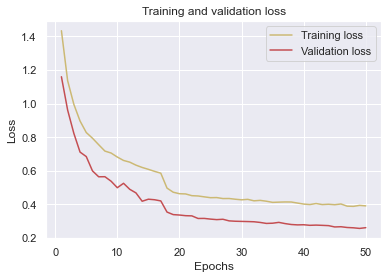

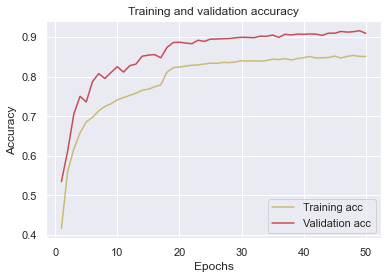

In [99]:
score = model.evaluate(x_test, y_test)
print('Accuracy:', score[1])


#Plot the training and validation accuracy and loss 
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Calssification report and Confusion matrix

294/294 [==============================] - 3s 10ms/step
[[1295    0    0    0    0    0    0]
 [   8 1293   19    0    0    0    3]
 [  44   42 1139    4   73   47    2]
 [   0    0    0 1392    0    0    0]
 [  13    9  120    0 1127   42    1]
 [  13   42  164    8  206  900   13]
 [   0    0    0    0    0    0 1368]]
                                     precision    recall  f1-score   support

          Actinic keratoses (akiec)       0.94      1.00      0.97      1295
         Basal cell carcinoma (bcc)       0.93      0.98      0.95      1323
Benign keratosis-like lesions (bkl)       0.79      0.84      0.82      1351
                Dermatofibroma (df)       0.99      1.00      1.00      1392
                     Melanoma (mel)       0.80      0.86      0.83      1312
              Melanocytic nevi (nv)       0.91      0.67      0.77      1346
            Vascular lesions (vasc)       0.99      1.00      0.99      1368

                           accuracy                        

<AxesSubplot:>

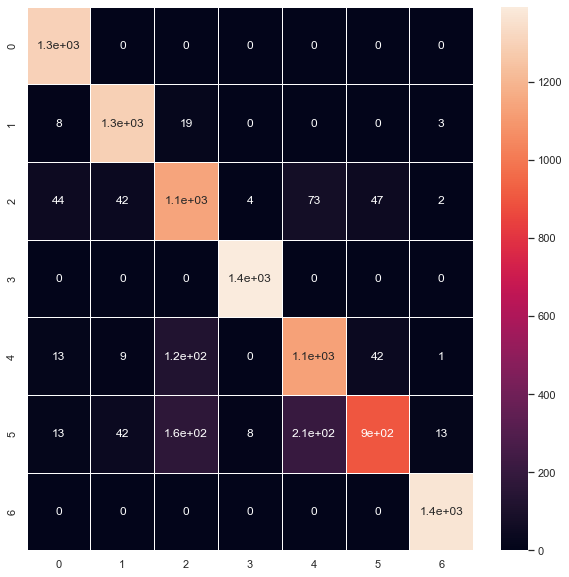

In [100]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 


#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)
#Print classification_report
print(classification_report(y_true, y_pred_classes,target_names=labels.values()))
fig, ax = plt.subplots(figsize=(10,10))
sns.set(font_scale=1)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)



In [111]:
x_test.shape

(9387, 32, 32, 3)

In [121]:
a=x_test[0]


In [122]:
a.shape

(32, 32, 3)

In [124]:
a=a.reshape(1,32,32,3)
a.shape

(1, 32, 32, 3)

In [125]:
y_pred = model.predict(a)

1/1 [==============================] - 0s 313ms/step


In [126]:
y_pred

array([[1.22257648e-02, 3.19363736e-02, 7.62774706e-01, 3.98989543e-02,
        4.25089933e-02, 1.10572934e-01, 8.22606016e-05]], dtype=float32)

Text(0, 0.5, 'Percent of incorrect predictions')

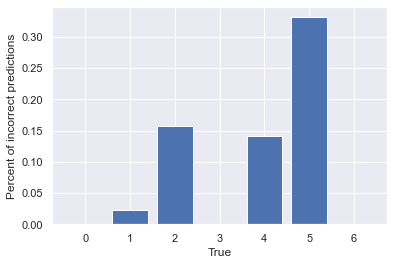

In [101]:
#Incorrect classifications
incorr = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr)
plt.xlabel('True')
plt.ylabel('Percent of incorrect predictions')

### Save the model and weights

In [102]:
model_json = model.to_json()
with open("modelmk.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("modelmk.h5")

----------

array([[1.22257648e-02, 3.19363736e-02, 7.62774706e-01, 3.98989543e-02,
        4.25089933e-02, 1.10572934e-01, 8.22606016e-05]], dtype=float32)